In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pneumonia/Pneumonia/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/pneumonia/Pneumonia/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/pneumonia/Pneumonia/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/pneumonia/Pneumonia/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/pneumonia/Pneumonia/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/pneumonia/Pneumonia/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/pneumonia/Pneumonia/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/pneumonia/Pneumonia/val/PNEUMONIA/person1950_bacteria_4881.jpeg
/kaggle/input/pneumonia/Pneumonia/val/NORMAL/NORMAL2-IM-1431-0001.jpeg
/kaggle/input/pneumonia/Pneumonia/val/NORMAL/NORMAL2-IM-1440-0001.jpeg
/kaggle/input/pneumonia/Pneumonia/val/NORMAL/NORMAL2-IM-1442-0001.jpeg
/kaggle/input/pneumonia/Pneumonia/val/NORMAL/NORMAL2-IM-1427-0001.jpeg
/kaggle/input/pneumonia/Pneumonia/val/NORMAL/NORMAL2-IM-1430-0001.jpeg
/kaggle/input/pneumon

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import glob
import numpy as np
from sklearn.metrics import confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

# --- Data Directories ---
base_dir = "/kaggle/input/pneumonia"
train_dir = os.path.join(base_dir, "Pneumonia/train")
val_dir   = os.path.join(base_dir, "Pneumonia/val")
test_dir  = os.path.join(base_dir, "Pneumonia/test")

# --- Data Generators with Augmentation ---
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='binary', shuffle=True
)
val_gen = val_datagen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='binary', shuffle=False
)
test_gen = test_datagen.flow_from_directory(
    test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='binary', shuffle=False
)


2025-07-19 03:42:46.427787: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752896566.818251      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752896566.933998      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [3]:
# --- Build Model: Pre-trained ResNet50 as Base ---
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

base_model = ResNet50(weights='imagenet', include_top=False,
                      input_shape=(224,224,3))
base_model.trainable = False  # Freeze the convolutional base (feature extractor)

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)  # Binary output
model = Model(inputs=base_model.input, outputs=output)

# Compile model for initial training
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auroc')]
)


I0000 00:00:1752896587.036312      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752896587.037087      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [4]:
# --- Callbacks for Training Stability ---
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
]

# --- Training Stage 1: Train new top layers (feature extraction) ---
initial_epochs = 10
history1 = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    validation_data=val_gen,
    validation_steps=len(val_gen),
    epochs=initial_epochs,
    callbacks=callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1752896602.914036      87 service.cc:148] XLA service 0x7ff7140016e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752896602.915779      87 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752896602.915803      87 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1752896604.504518      87 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/163 ━━━━━━━━━━━━━━━━━━━━ 13s 82ms/step - accuracy: 0.5391 - auroc: 0.4359 - loss: 0.6805 

I0000 00:00:1752896609.960895      87 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


163/163 ━━━━━━━━━━━━━━━━━━━━ 138s 742ms/step - accuracy: 0.6256 - auroc: 0.5054 - loss: 0.6658 - val_accuracy: 0.5000 - val_auroc: 0.2422 - val_loss: 0.8638 - learning_rate: 1.0000e-04
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 91s 561ms/step - accuracy: 0.7072 - auroc: 0.4951 - loss: 0.6309 - val_accuracy: 0.5000 - val_auroc: 0.4375 - val_loss: 0.8497 - learning_rate: 1.0000e-04
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 90s 554ms/step - accuracy: 0.7083 - auroc: 0.5083 - loss: 0.6167 - val_accuracy: 0.5000 - val_auroc: 0.5000 - val_loss: 0.8450 - learning_rate: 1.0000e-04
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 91s 555ms/step - accuracy: 0.7238 - auroc: 0.5008 - loss: 0.6114 - val_accuracy: 0.5000 - val_auroc: 0.5938 - val_loss: 0.8332 - learning_rate: 1.0000e-04
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 90s 553ms/step - accuracy: 0.7451 - auroc: 0.4934 - loss: 0.5884 - val_accuracy: 0.5000 - val_auroc: 0.8125 - val_loss: 0.8167 - learning_rate: 1.0000e-04
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━

In [5]:
# --- Fine-tuning: Unfreeze and train some base layers ---
# Unfreeze the top layers of the base model for fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Recompile with lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.AUC(name='auroc')]
)

fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs
history2 = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    validation_data=val_gen,
    validation_steps=len(val_gen),
    epochs=total_epochs,
    initial_epoch=history1.epoch[-1] + 1,
    callbacks=callbacks
)

# Load the best model weights (lowest validation loss)
model.load_weights("best_model.h5")


Epoch 11/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 116s 583ms/step - accuracy: 0.8048 - auroc: 0.8556 - loss: 0.4041 - val_accuracy: 0.5000 - val_auroc: 0.8516 - val_loss: 0.7441 - learning_rate: 1.0000e-05
Epoch 12/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 89s 542ms/step - accuracy: 0.9050 - auroc: 0.9618 - loss: 0.2227 - val_accuracy: 0.5000 - val_auroc: 0.8438 - val_loss: 0.9889 - learning_rate: 1.0000e-05
Epoch 13/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 90s 550ms/step - accuracy: 0.9264 - auroc: 0.9713 - loss: 0.1895 - val_accuracy: 0.5000 - val_auroc: 0.6719 - val_loss: 2.1032 - learning_rate: 1.0000e-05
Epoch 14/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 89s 544ms/step - accuracy: 0.9285 - auroc: 0.9778 - loss: 0.1691 - val_accuracy: 0.5625 - val_auroc: 0.8594 - val_loss: 1.0423 - learning_rate: 5.0000e-06


In [6]:
# --- Evaluation on Test Set ---
y_true = test_gen.classes
y_prob = model.predict(test_gen, steps=len(test_gen), verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(int)

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)
auc = roc_auc_score(y_true, y_prob)
print("Test AUC:", auc)
acc = np.mean(y_pred == y_true)
print(f"Test Accuracy: {acc:.4f}")


Confusion matrix:
 [[  0 234]
 [  0 390]]
Test AUC: 0.5840346263423186
Test Accuracy: 0.6250


Confusion matrix:
 [[  0 234]
 [  0 390]]


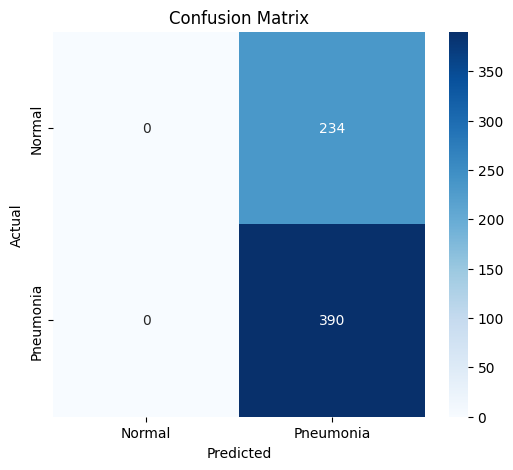

Test AUC: 0.5840


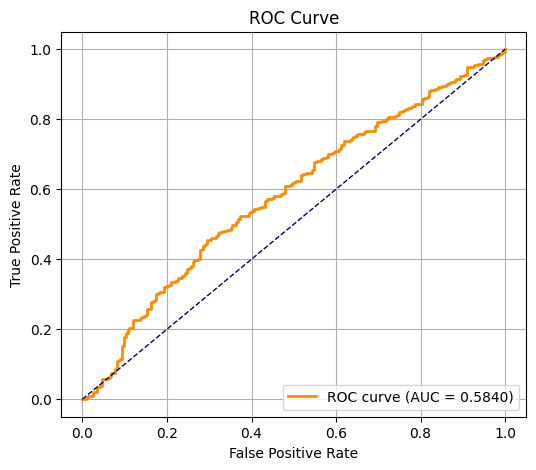

Test Accuracy: 62.50%


In [7]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Evaluation on Test Set ---
y_true = test_gen.classes
y_prob = model.predict(test_gen, steps=len(test_gen), verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

# Visualisasi Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC AUC Score dan ROC Curve
auc = roc_auc_score(y_true, y_prob)
print(f"Test AUC: {auc:.4f}")

fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Accuracy
acc = np.mean(y_pred == y_true)
print(f"Test Accuracy: {acc * 100:.2f}%")


In [8]:
from tensorflow import keras
import numpy as np
from PIL import Image

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Muat gambar dan konversi ke array
    img = keras.preprocessing.image.load_img(img_path)
    img_array = keras.preprocessing.image.img_to_array(img)

    # Buat heatmap RGB dari array heatmap
    jet = plt.cm.get_cmap("jet")
    jet_heatmap = jet(heatmap)[:, :, :3] * 255
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    
    # Resize heatmap agar sesuai dengan ukuran gambar
    jet_heatmap = jet_heatmap.resize((img_array.shape[1], img_array.shape[0]))
    jet_heatmap_array = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Lakukan superimpose heatmap dengan gambar asli
    superimposed_array = jet_heatmap_array * alpha + img_array

    # Pastikan nilai dalam rentang uint8 lalu simpan hasilnya
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_array)
    superimposed_img.save(cam_path)


In [9]:
# --- Grad-CAM Visualization ---

from tensorflow import keras
import numpy as np
from PIL import Image

def get_img_array(img_path, size=(224,224)):
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img) / 255.0
    return np.expand_dims(array, axis=0)

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output[0]
    heatmap = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Muat gambar dan konversi ke array
    img = keras.preprocessing.image.load_img(img_path)
    img_array = keras.preprocessing.image.img_to_array(img)

    # Buat heatmap RGB dari array heatmap
    jet = plt.cm.get_cmap("jet")
    jet_heatmap = jet(heatmap)[:, :, :3] * 255
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    
    # Resize heatmap agar sesuai dengan ukuran gambar
    jet_heatmap = jet_heatmap.resize((img_array.shape[1], img_array.shape[0]))
    jet_heatmap_array = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Lakukan superimpose heatmap dengan gambar asli
    superimposed_array = jet_heatmap_array * alpha + img_array

    # Pastikan nilai dalam rentang uint8 lalu simpan hasilnya
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_array)
    superimposed_img.save(cam_path)

# Directory containing X-ray images for Grad-CAM
heatmap_dir = ("/kaggle/input/data-radiolog/data pneumonia radiolog 111124/"
               "data pneumonia radiolog 111124/data numbered14-10-24/26-09 (Sudah Blur)/BLM BLUR (Sudah Blur)")
all_imgs = glob.glob(os.path.join(heatmap_dir, "*.jpg"))

# Collect example images for each predicted class
pneumonia_paths = []
normal_paths = []
for img_path in all_imgs:
    img_array = get_img_array(img_path)
    pred_prob = model.predict(img_array)[0][0]
    if pred_prob >= 0.5 and len(pneumonia_paths) < 5:
        pneumonia_paths.append(img_path)
    if pred_prob < 0.5 and len(normal_paths) < 5:
        normal_paths.append(img_path)
    if len(pneumonia_paths) >= 5 and len(normal_paths) >= 5:
        break

# Create output directory for Grad-CAM results
output_dir = "/kaggle/working/gradcam_results"
os.makedirs(output_dir, exist_ok=True)

last_conv_layer_name = "conv5_block3_out"
# Generate and save heatmaps (pneumonia samples labeled 'pneumonia_i.jpg')
for idx, img_path in enumerate(pneumonia_paths, start=1):
    img_array = get_img_array(img_path)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    out_path = os.path.join(output_dir, f"pneumonia_{idx}.jpg")
    save_and_display_gradcam(img_path, heatmap, cam_path=out_path)

# Generate and save heatmaps (normal samples labeled 'normal_i.jpg')
for idx, img_path in enumerate(normal_paths, start=1):
    img_array = get_img_array(img_path)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    out_path = os.path.join(output_dir, f"normal_{idx}.jpg")
    save_and_display_gradcam(img_path, heatmap, cam_path=out_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/tmp/ipykernel_19/1424022302.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


In [10]:
# --- Grad-CAM Visualization ---

from tensorflow import keras
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os, glob

def get_img_array(img_path, size=(224,224)):
    # --- MODIFIKASI: crop keluar color‑bar di kiri & kanan sebelum resize ---
    img = keras.preprocessing.image.load_img(img_path)  # load original size
    w, h = img.size
    # asumsikan color‑bar ~10% di kiri dan kanan
    left = int(w * 0.10)
    right = int(w * 0.90)
    img = img.crop((left, 0, right, h))
    # lalu resize ke target_size
    img = img.resize(size)
    array = keras.preprocessing.image.img_to_array(img) / 255.0
    return np.expand_dims(array, axis=0)
    # --- END MODIFIKASI ---

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output[0]
    heatmap = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Muat gambar dan konversi ke array
    img = keras.preprocessing.image.load_img(img_path)
    img_array = keras.preprocessing.image.img_to_array(img)

    # Buat heatmap RGB dari array heatmap
    jet = plt.cm.get_cmap("jet")
    jet_heatmap = jet(heatmap)[:, :, :3] * 255
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    
    # Resize heatmap agar sesuai dengan ukuran gambar
    jet_heatmap = jet_heatmap.resize((img_array.shape[1], img_array.shape[0]))
    jet_heatmap_array = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Lakukan superimpose heatmap dengan gambar asli
    superimposed_array = jet_heatmap_array * alpha + img_array

    # Pastikan nilai dalam rentang uint8 lalu simpan hasilnya
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_array)
    superimposed_img.save(cam_path)

# Directory containing X-ray images for Grad-CAM
heatmap_dir = ("/kaggle/input/data-radiolog/data pneumonia radiolog 111124/"
               "data pneumonia radiolog 111124/data numbered14-10-24/26-09 (Sudah Blur)/BLM BLUR (Sudah Blur)")
all_imgs = glob.glob(os.path.join(heatmap_dir, "*.jpg"))

# Collect example images for each predicted class
pneumonia_paths = []
normal_paths = []
for img_path in all_imgs:
    img_array = get_img_array(img_path)
    pred_prob = model.predict(img_array)[0][0]
    if pred_prob >= 0.5 and len(pneumonia_paths) < 5:
        pneumonia_paths.append(img_path)
    if pred_prob < 0.5 and len(normal_paths) < 5:
        normal_paths.append(img_path)
    if len(pneumonia_paths) >= 5 and len(normal_paths) >= 5:
        break

# Create output directory for Grad-CAM results
output_dir = "/kaggle/working/gradcam_results"
os.makedirs(output_dir, exist_ok=True)

last_conv_layer_name = "conv5_block3_out"
# Generate and save heatmaps (pneumonia samples labeled 'pneumonia_i.jpg')
for idx, img_path in enumerate(pneumonia_paths, start=1):
    img_array = get_img_array(img_path)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    out_path = os.path.join(output_dir, f"pneumonia_{idx}.jpg")
    save_and_display_gradcam(img_path, heatmap, cam_path=out_path)

# Generate and save heatmaps (normal samples labeled 'normal_i.jpg')
for idx, img_path in enumerate(normal_paths, start=1):
    img_array = get_img_array(img_path)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    out_path = os.path.join(output_dir, f"normal_{idx}.jpg")
    save_and_display_gradcam(img_path, heatmap, cam_path=out_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

/tmp/ipykernel_19/855164081.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = plt.cm.get_cmap("jet")


In [11]:
# Setelah selesai fine‑tuning dan load_weights:
model.save("/kaggle/working/final_pneumonia_model_best.h5")
print("Model lengkap tersimpan di /kaggle/working/final_pneumonia_detect.h5")


Model lengkap tersimpan di /kaggle/working/final_pneumonia_detect.h5


In [12]:
# Menyimpan model lengkap dalam format .keras
model.save("/kaggle/working/final_pneumonia_model_best.keras")
print("Model tersimpan sebagai file Keras di /kaggle/working/final_pneumonia_model_best.keras")


Model tersimpan sebagai file Keras di /kaggle/working/final_pneumonia_model_best.keras


In [13]:
# Ekspor ke SavedModel (folder)
model.export("/kaggle/working/pneumonia_saved_model")
print("SavedModel tersimpan di /kaggle/working/pneumonia_saved_model/")


Saved artifact at '/kaggle/working/pneumonia_saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140703187883152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140703187883920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140703187883344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140703187884496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140703187882000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140703187882960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140703187887568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140703187889104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140703187890064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140703187887760: TensorSpec(shape=(), dtype=tf.resource, name=N

In [14]:
import shutil

# Kompres folder ke zip
shutil.make_archive("/kaggle/working/pneumonia_saved_model", 'zip', "/kaggle/working/pneumonia_saved_model")
print("Folder berhasil dikompres menjadi pneumonia_saved_model.zip")


Folder berhasil dikompres menjadi pneumonia_saved_model.zip
